In [1]:
import os
import cv2
import numpy as np

img_size = (150, 150)

train_dir = '../dataset/train'
validation_dir = '../dataset/val'
test_dir = '../dataset/test'

def resize_images_from_directory(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):
            img_path = os.path.join(label_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(label)

    if (directory == train_dir):
        images = images[:3500]
        labels = labels[:3500]

    return np.array(images), np.array(labels)


X_train, y_train = resize_images_from_directory(train_dir)
X_validation, y_validation = resize_images_from_directory(validation_dir)
X_test, y_test = resize_images_from_directory(test_dir)

X_train_reshape = X_train.reshape(X_train.shape[0], -1)
X_validation_reshape = X_validation.reshape(X_validation.shape[0], -1)
X_test_reshape = X_test.reshape(X_test.shape[0], -1)

Number of files in the folder normal : 1341
Number of files in the folder pneumonia : 3875
Class Distribution Before SMOTE: Counter({'PNEUMONIA': 2159, 'NORMAL': 1341})
Class Distribution After SMOTE: Counter({'NORMAL': 2159, 'PNEUMONIA': 2159})


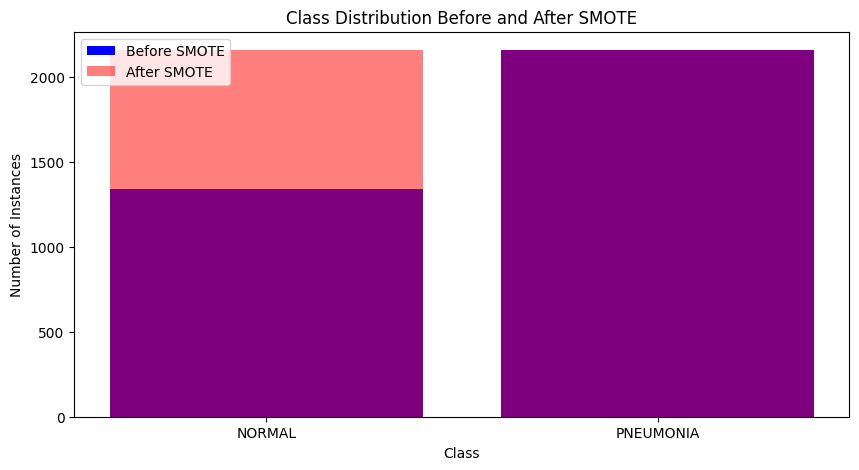

In [2]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter

def count_files(folder_path):
    count = 0
    for _, _, files in os.walk(folder_path):
        count += len(files)
    return count

folder_path_normal = "../dataset/train/NORMAL"
folder_path_pneumonia = "../dataset/train/PNEUMONIA"
num_files_normal = count_files(folder_path_normal)
num_files_pneumonia = count_files(folder_path_pneumonia)
print("Number of files in the folder normal :", num_files_normal)
print("Number of files in the folder pneumonia :", num_files_pneumonia)

counter_before = Counter(y_train)
print("Class Distribution Before SMOTE:", counter_before)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshape, y_train)  

counter_after = Counter(y_train_resampled)
print("Class Distribution After SMOTE:", counter_after)

plt.figure(figsize=(10, 5))
plt.bar(counter_before.keys(), counter_before.values(), color='b', label='Before SMOTE')
plt.bar(counter_after.keys(), counter_after.values(), color='r', alpha=0.5, label='After SMOTE')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution Before and After SMOTE')
plt.legend()
plt.show()

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC

param = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'dual': [True, False],
    'C':[0.001, 0.01, 0.1, 1, 10, 100],
}

grid = GridSearchCV(LinearSVC(), param, cv=5, scoring='accuracy')
grid.fit(X_validation_reshape, y_validation)

C:\Users\hugod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\hugod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\hugod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\hugod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear 

GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'dual': [True, False],
                         'loss': ['hinge', 'squared_hinge'],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [5]:
best_params = grid.best_params_
best_score = grid.best_score_
best_estimator = grid.best_estimator_

print("Best parameters:", best_params)
print("Best score:", best_score)
print('Score with best estimator:', best_estimator.score(X_test_reshape, y_test))

confusion_matrix(y_validation, best_estimator.predict(X_validation_reshape))

Best parameters: {'C': 0.01, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'}
Best score: 0.75
Score with best estimator: 0.5048076923076923


array([[8, 0],
       [0, 8]], dtype=int64)

In [7]:
model = LinearSVC(C=0.01, dual=False, loss='squared_hinge', penalty='l1')
model.fit(X_train_resampled, y_train_resampled)
model.score(X_validation_reshape, y_validation)

C:\Users\hugod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9375

Success Rate: 0.7612179487179487
Success Rate for Pneumonia: 0.9692307692307692
Success Rate for Normal: 0.41452991452991456


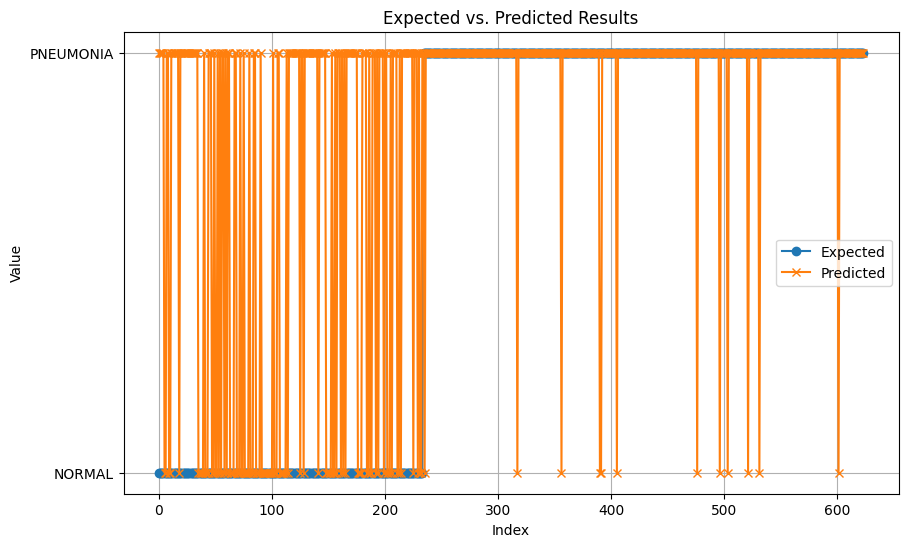

In [8]:
predictions = model.predict(X_test_reshape)
indices = np.arange(len(y_test))

def success_rate() :
    num_correct = sum(y_test == predictions)
    total_predictions = len(y_test)
    return num_correct / total_predictions

def success_rate_per_class(class_name):
    expected = y_test[y_test == class_name]
    predicted = predictions[y_test == class_name]
    num_correct = sum(expected == predicted)
    total_predictions = len(expected)
    return num_correct / total_predictions

print("Success Rate:", success_rate())
print("Success Rate for Pneumonia:", success_rate_per_class('PNEUMONIA'))
print("Success Rate for Normal:", success_rate_per_class('NORMAL'))

plt.figure(figsize=(10, 6))
plt.plot(indices, y_test, label='Expected', marker='o')
plt.plot(indices, predictions, label='Predicted', marker='x')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Expected vs. Predicted Results')
plt.legend()
plt.grid(True)
plt.show()